In [3]:
print(df.columns)


Index(['title', 'link', 'published_date', 'is_hourly', 'hourly_low',
       'hourly_high', 'budget', 'country'],
      dtype='object')


/tmp/ipython-input-4108145980.py:43: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['month'] = df['published_date'].dt.to_period('M').astype(str)


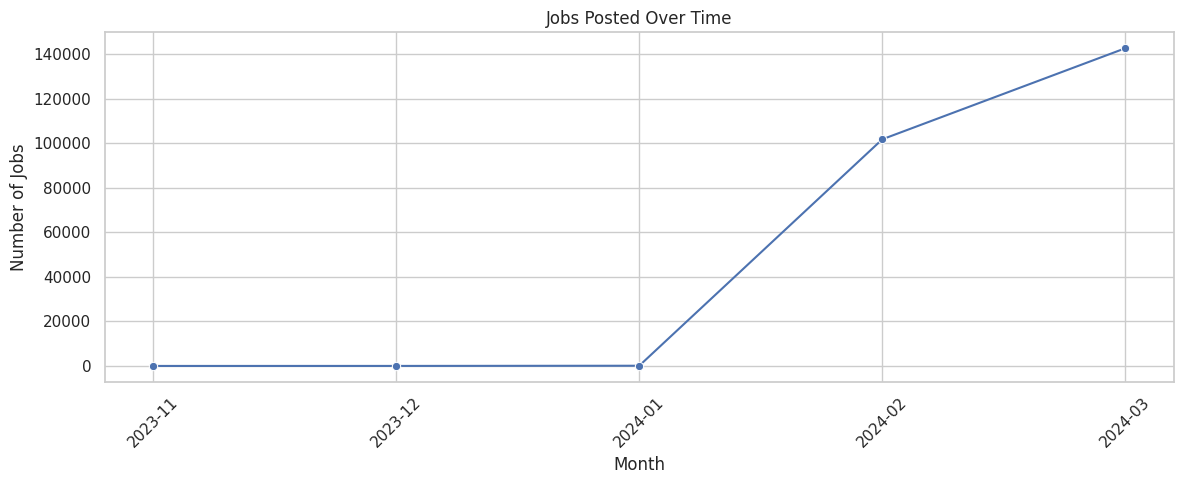

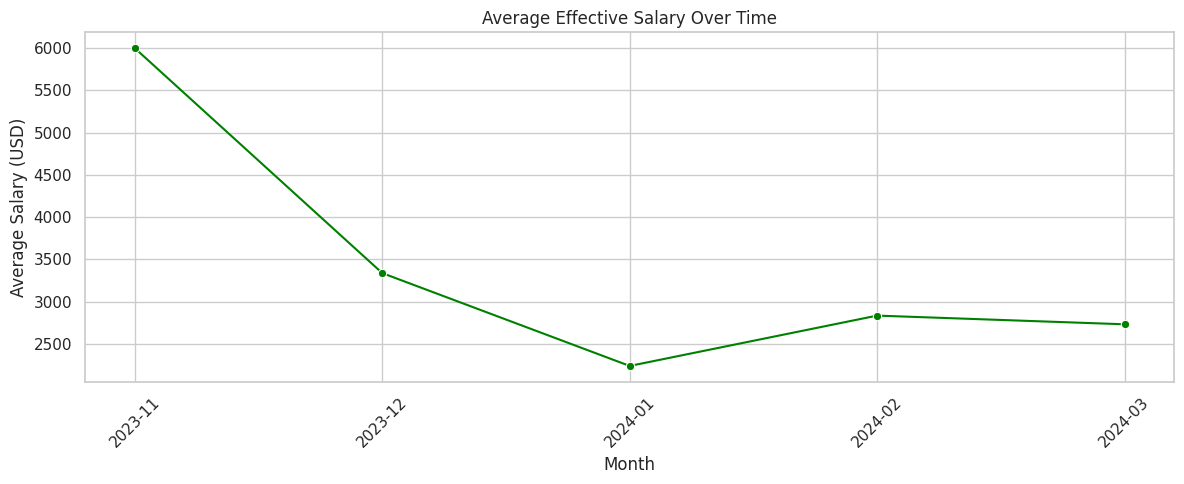

/tmp/ipython-input-4108145980.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")


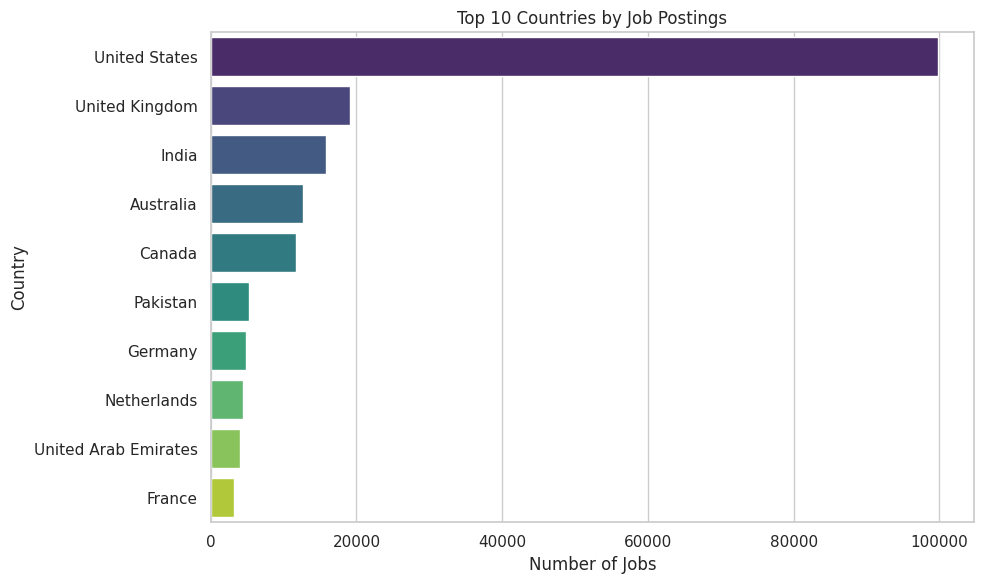

In [10]:
# ----------------------------
# Install dependencies (run once)
# ----------------------------
!pip install pandas matplotlib seaborn --quiet

# ----------------------------
# Imports
# ----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# ----------------------------
# Load dataset
# ----------------------------
df = pd.read_csv("/content/all_upwork_jobs.csv", encoding="latin1", on_bad_lines="skip")

# ----------------------------
# Preprocess data
# ----------------------------

# Convert salaries to numeric
for col in ["hourly_low", "hourly_high", "budget"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Compute average hourly and monthly salary
df["avg_hourly"] = df[["hourly_low","hourly_high"]].mean(axis=1)
df["hourly_monthly"] = df["avg_hourly"] * 160
df["effective_salary"] = df.apply(
    lambda r: r["hourly_monthly"] if pd.notna(r.get("hourly_monthly")) and r.get("is_hourly", False)
    else r.get("budget", 0),
    axis=1
)

# Convert published_date to datetime
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.dropna(subset=['published_date'])  # drop invalid dates

# Extract month-year as string for plotting
df['month'] = df['published_date'].dt.to_period('M').astype(str)

# ----------------------------
# Monthly job count trend
# ----------------------------
monthly_trends = df.groupby('month').size().reset_index(name='job_count')

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_trends, x='month', y='job_count', marker='o')
plt.xticks(rotation=45)
plt.title("Jobs Posted Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.tight_layout()
plt.show()

# ----------------------------
# Monthly average effective salary
# ----------------------------
monthly_salary = df.groupby('month')['effective_salary'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(data=monthly_salary, x='month', y='effective_salary', marker='o', color='green')
plt.xticks(rotation=45)
plt.title("Average Effective Salary Over Time")
plt.xlabel("Month")
plt.ylabel("Average Salary (USD)")
plt.tight_layout()
plt.show()

# ----------------------------
# Top 10 countries by job postings
# ----------------------------
top_countries = df['country'].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_countries.values, y=top_countries.index, palette="viridis")
plt.title("Top 10 Countries by Job Postings")
plt.xlabel("Number of Jobs")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [11]:
!pip install prophet pandas matplotlib seaborn --quiet


/tmp/ipython-input-1324145238.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_trends = df.groupby(df['published_date'].dt.to_period('M')).size().reset_index(name='job_count')
INFO:prophet:n_changepoints greater than number of observations. Using 3.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca0beno2/hch63pi6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpca0beno2/r9hc580m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75344', 'data', 'file=/tmp/tmpca0beno2/hch63pi6.json', 'init=/tmp/tmpca0beno2/r9hc580m.json', 'output', 'file=/tmp/tmpca0beno2/prophet_model24rnlvih/prophet_model-20250907232844.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
23:28:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:28:44 - cmdstanpy - INFO 

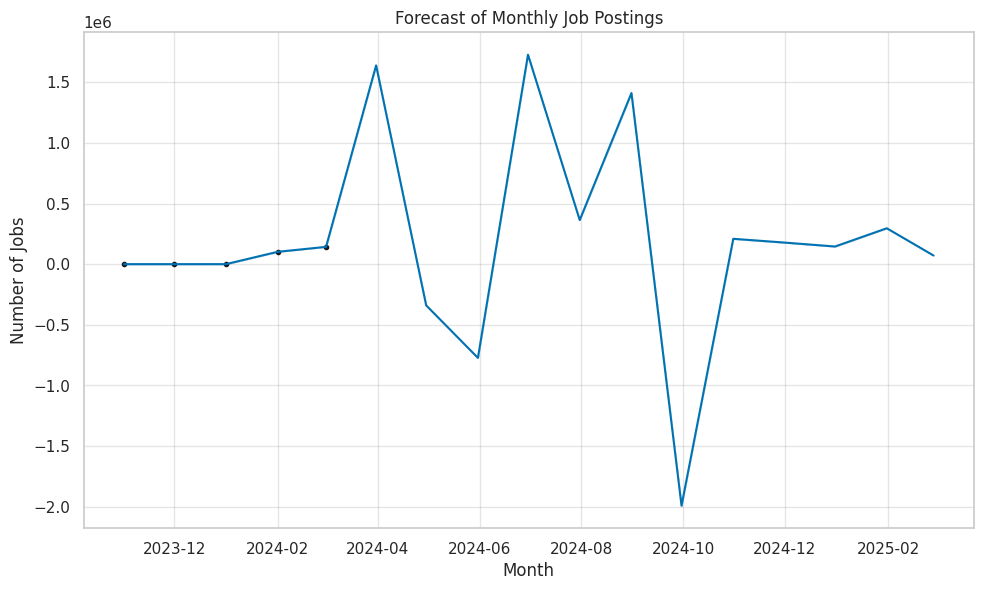

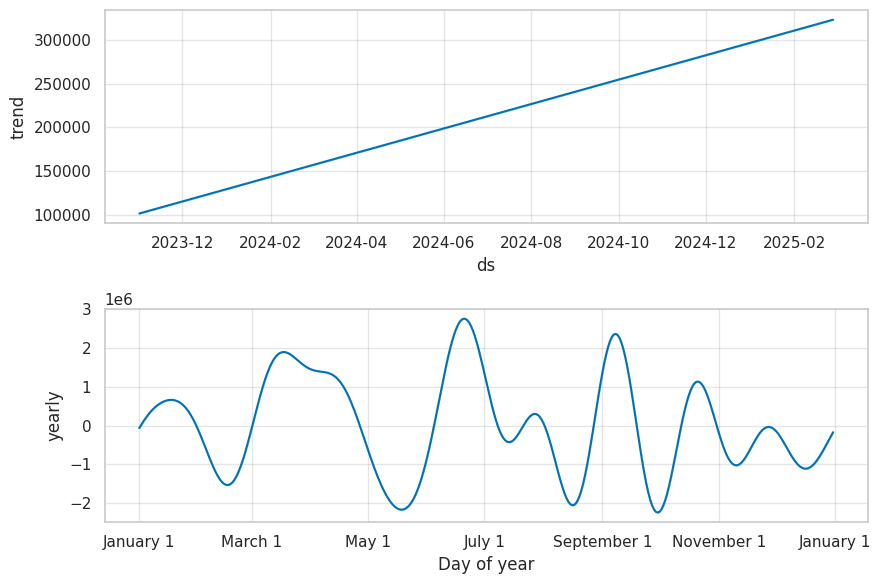

In [12]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("/content/all_upwork_jobs.csv", encoding="latin1", on_bad_lines="skip")

# Preprocess dates
df['published_date'] = pd.to_datetime(df['published_date'], errors='coerce')
df = df.dropna(subset=['published_date'])

# Aggregate by month
monthly_trends = df.groupby(df['published_date'].dt.to_period('M')).size().reset_index(name='job_count')
monthly_trends['month'] = monthly_trends['published_date'].dt.to_timestamp()

# Prepare Prophet dataframe
prophet_df = monthly_trends.rename(columns={'month': 'ds', 'job_count': 'y'})

# Initialize and fit Prophet model
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(prophet_df)

# Create future dataframe (next 12 months)
future = model.make_future_dataframe(periods=12, freq='M')

# Predict future job postings
forecast = model.predict(future)

# Plot forecast
fig1 = model.plot(forecast)
plt.title("Forecast of Monthly Job Postings")
plt.xlabel("Month")
plt.ylabel("Number of Jobs")
plt.show()

# Optional: plot forecast components (trend, yearly seasonality)
fig2 = model.plot_components(forecast)
plt.show()
